# Train the KNN classifier

Training of the **$k$ nearest neighbors classifier** for producing results with various **degrees of dataset imbalance**. The trained model is further saved to reproduce the results for testing.

## Import useful packages

In [630]:
# Generic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle
import sys

In [631]:
# Sci-kit learn for machine learning tasks
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, make_scorer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

In [632]:
# NLTK for natural language processing
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [633]:
# Custom helper-functions script (supplied to Colab manually)
import utils as uu

## Define the machine-learning model

Best hyperparams:  {'leaf_size': 97.0, 'max_features': 361035.0, 'n_neighbors': 3.0, 'p': 1, 'vectorizer': 0, 'weights': 1}

In [634]:
# Set parameters tuned beforehand via Bayesian optimization
params = {'leaf_size':      35,
          'n_neighbors':    15,
          'max_features':   406869,
          'vectorizer':     'tfidf',
          'weights':        'uniform'
          }

## Load the datasets

In [635]:
# Set file names
train_set_file  = "train_set_imb_0.csv"
test_set_file   = "test_set_imb_0.csv"
model_file      = "model_knn_imb_0.pckl"

In [636]:
# Read train and test sets as dataframes
train_set = pd.read_csv(train_set_file)
test_set = pd.read_csv(test_set_file)

In [637]:
# Preprocess texts
train_set['text'] = train_set['text'].apply(str)
train_set['text'] = train_set['text'].apply(uu.preprocess_text)
test_set['text'] = test_set['text'].apply(str)
test_set['text'] = test_set['text'].apply(uu.preprocess_text)

In [638]:
# Decouple texts and labels (deep copy to not modfy the original datasets accidentally)
texts_train = copy.deepcopy(train_set['text'])
labels_train = copy.deepcopy(train_set['is_about_cc'])
texts_test = copy.deepcopy(test_set['text'])
labels_test = copy.deepcopy(test_set['is_about_cc'])

In [639]:
# Show the test obtained set fraction (should be 15%)
share_test = len(labels_test)/(len(labels_train)+len(labels_test))
print(share_test)

0.149886976178056


## Create features and fit the model

In [640]:
# Set vectorizer
if params['vectorizer']=='tfidf':
    vectorizer = TfidfVectorizer(max_features=params['max_features'], lowercase=True, analyzer='word', dtype=np.float32)
elif params['vectorizer']=='count':
    vectorizer = CountVectorizer()
else:
    sys.exit("Unsupported vectorizer!")

# Fit vectorizer
vectorizer.fit(texts_train)
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)

In [641]:
# Compute class weights for compensation the imbalance in classes
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(labels_train), y = labels_train)
class_weights = dict(zip(np.unique(labels_train), class_weights))
print(class_weights)

{0: 0.540579389650597, 1: 6.660762942779291}


In [642]:
# Define the model
model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], p=2, leaf_size=params['leaf_size'], weights='distance', algorithm='auto')

In [643]:
# Fit the model
model.fit(features_train, labels_train)

KNeighborsClassifier(leaf_size=35, n_neighbors=15, weights='distance')

In [644]:
# Save model (needs to be downloaded manyally from Colab)
pickle.dump(model, open(model_file, 'wb'))

## Test the model for performance

In [645]:
# Compute PR AUC score (area under the precision-recall curve)
prediction_scores = model.predict_proba(features_test)[:, 1]
precs, recs = uu.compute_pr(labels_test, prediction_scores)
pr_auc = auc(recs, precs)
pr_auc

0.5982378344186514

In [646]:
# Compute F1 score
predicted_labels = (model.predict(features_test) > 0.5).astype(int)
acc, prec, rec, f1 = uu.compute_perf_metrics(labels_test, predicted_labels)
print("f1 = ", f1)
print("prec = ", prec)
print("rec = ", rec)

f1 =  0.29333333333333333
prec =  1.0
rec =  0.171875


[[798   0]
 [ 53  11]]


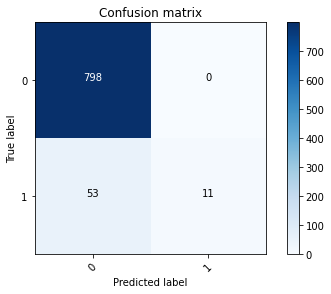

In [647]:
# Compute confusion matrix
confusion_mat = confusion_matrix(labels_test, predicted_labels)
print(confusion_mat)
uu.plot_confusion_matrix(confusion_mat, classes=[0, 1], title='Confusion matrix')

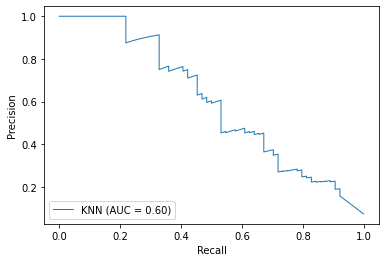

In [648]:
# Plot precision-recall curve
plt.plot(recs, precs, linewidth=1, label=' '.join(['KNN', '(AUC = %0.2f)' % pr_auc]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")